# Preprocessing

In [ ]:
import pandas as pd
df = pd.read_csv("train_dataset.csv")

In [ ]:
df_val= pd.read_csv('validation_dataset.csv')

# DistilBERT

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting df
train_texts = df['reviewText'].tolist()  # Extracting 'reviewText' column
train_labels = df['overall'].tolist()    # Extracting 'overall' column

# Splitting df_val
val_texts = df_val['reviewText'].tolist()
val_labels = df_val['overall'].tolist()

# Load the pre-trained DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define maximum sequence length
max_seq_length = 512  # Choose an appropriate value for your data

# Tokenize all of the sentences and map the tokens to their word IDs
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_seq_length)
val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=max_seq_length)

# Convert the tokenized inputs into PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_encodings.input_ids),
                              torch.tensor(train_encodings.attention_mask),
                              torch.tensor(train_labels))
val_dataset = TensorDataset(torch.tensor(val_encodings.input_ids),
                            torch.tensor(val_encodings.attention_mask),
                            torch.tensor(val_labels))

# Define the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10

# Store predictions and true labels for each epoch
all_val_preds_epoch = []
all_val_true_epoch = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar_train:
        input_ids, attention_mask, labels = (t.to(device) for t in batch)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        progress_bar_train.set_postfix(train_loss=total_train_loss / len(progress_bar_train))

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_true = []
    progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    with torch.no_grad():
        for batch in progress_bar_val:
            input_ids, attention_mask, labels = (t.to(device) for t in batch)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_true.extend(labels.cpu().numpy())

            progress_bar_val.set_postfix(val_loss=total_val_loss / len(progress_bar_val))

    avg_val_loss = total_val_loss / len(val_loader)
    accuracy = accuracy_score(all_val_true, all_val_preds)

    print(f'Epoch {epoch + 1}:')
    print(f'  Train Loss: {avg_train_loss:.4f}')
    print(f'  Validation Loss: {avg_val_loss:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')

    # Append predictions and true labels for each epoch
    all_val_preds_epoch.append(all_val_preds)
    all_val_true_epoch.append(all_val_true)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/10: 100%|██████████| 125/125 [00:15<00:00,  8.05batch/s, val_loss=0.862]


Epoch 1:
  Train Loss: 0.9901
  Validation Loss: 0.8625
  Accuracy: 0.6250


Epoch 2/10: 100%|██████████| 125/125 [00:15<00:00,  7.82batch/s, val_loss=0.862]


Epoch 2:
  Train Loss: 0.7490
  Validation Loss: 0.8615
  Accuracy: 0.6300


Epoch 3/10: 100%|██████████| 125/125 [00:16<00:00,  7.79batch/s, val_loss=1.04]


Epoch 3:
  Train Loss: 0.5767
  Validation Loss: 1.0392
  Accuracy: 0.6080


Epoch 4/10: 100%|██████████| 125/125 [00:16<00:00,  7.79batch/s, val_loss=1.17]


Epoch 4:
  Train Loss: 0.4193
  Validation Loss: 1.1673
  Accuracy: 0.6340


Epoch 5/10: 100%|██████████| 125/125 [00:16<00:00,  7.78batch/s, val_loss=1.57]


Epoch 5:
  Train Loss: 0.3235
  Validation Loss: 1.5666
  Accuracy: 0.6190


Epoch 6/10: 100%|██████████| 125/125 [00:16<00:00,  7.80batch/s, val_loss=1.8]


Epoch 6:
  Train Loss: 0.2481
  Validation Loss: 1.7998
  Accuracy: 0.6100


Epoch 7/10: 100%|██████████| 125/125 [00:16<00:00,  7.79batch/s, val_loss=2.13]


Epoch 7:
  Train Loss: 0.1778
  Validation Loss: 2.1337
  Accuracy: 0.6100


Epoch 8/10: 100%|██████████| 125/125 [00:16<00:00,  7.79batch/s, val_loss=2.4]


Epoch 8:
  Train Loss: 0.1576
  Validation Loss: 2.3968
  Accuracy: 0.6260


Epoch 9/10: 100%|██████████| 125/125 [00:16<00:00,  7.77batch/s, val_loss=2.72]


Epoch 9:
  Train Loss: 0.0925
  Validation Loss: 2.7174
  Accuracy: 0.6120


Epoch 10/10: 100%|██████████| 125/125 [00:16<00:00,  7.80batch/s, val_loss=3.05]

Epoch 10:
  Train Loss: 0.0811
  Validation Loss: 3.0474
  Accuracy: 0.5980


Saving the model

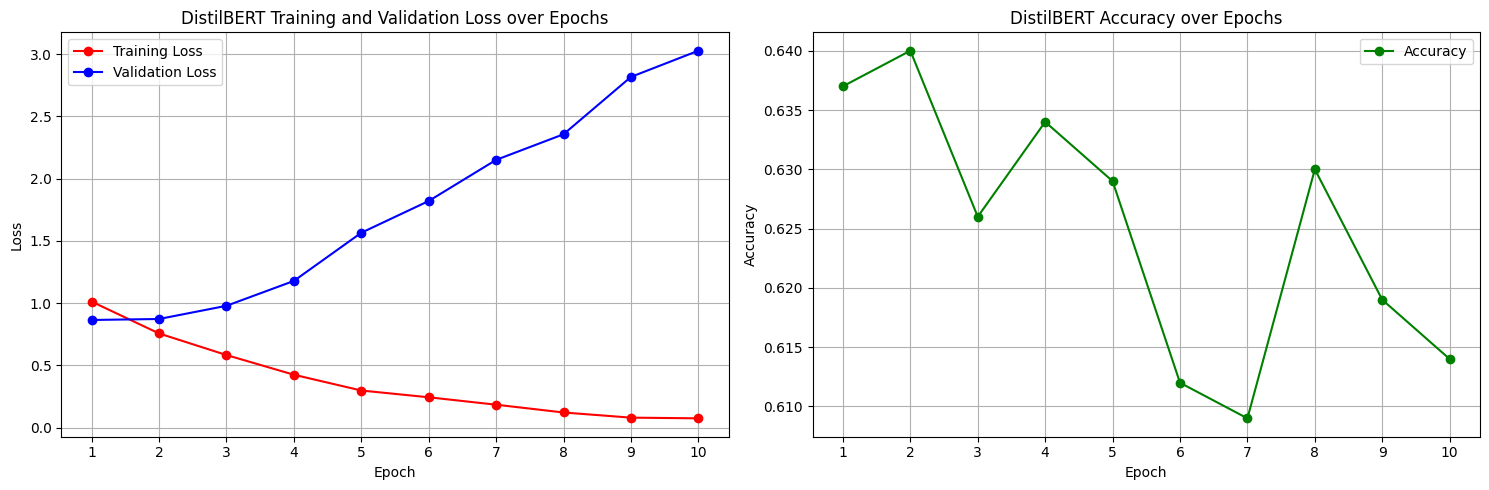

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = range(1,11)
training_loss = [1.0128, 0.7571, 0.5836, 0.4254, 0.2986, 0.2442, 0.1846, 0.1220, 0.0806, 0.0750]
validation_loss = [0.8652, 0.8732, 0.9791, 1.1790, 1.5659, 1.8210, 2.1514, 2.3573, 2.8179, 3.0285]
accuracy = [0.6370, 0.6400, 0.6260, 0.6340, 0.6290, 0.6120, 0.6090, 0.6300, 0.6190, 0.6140]

# Plotting
plt.figure(figsize=(15, 5))

# Training and Validation Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, marker='o', label='Training Loss', color='red')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss', color='blue')
plt.title('DistilBERT Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)  # Set x-ticks to display integers starting from 1
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, marker='o', label='Accuracy', color='green')
plt.title('DistilBERT Accuracy over Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)  # Set x-ticks to display integers starting from 1
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
